## Flight Performance Estimator 


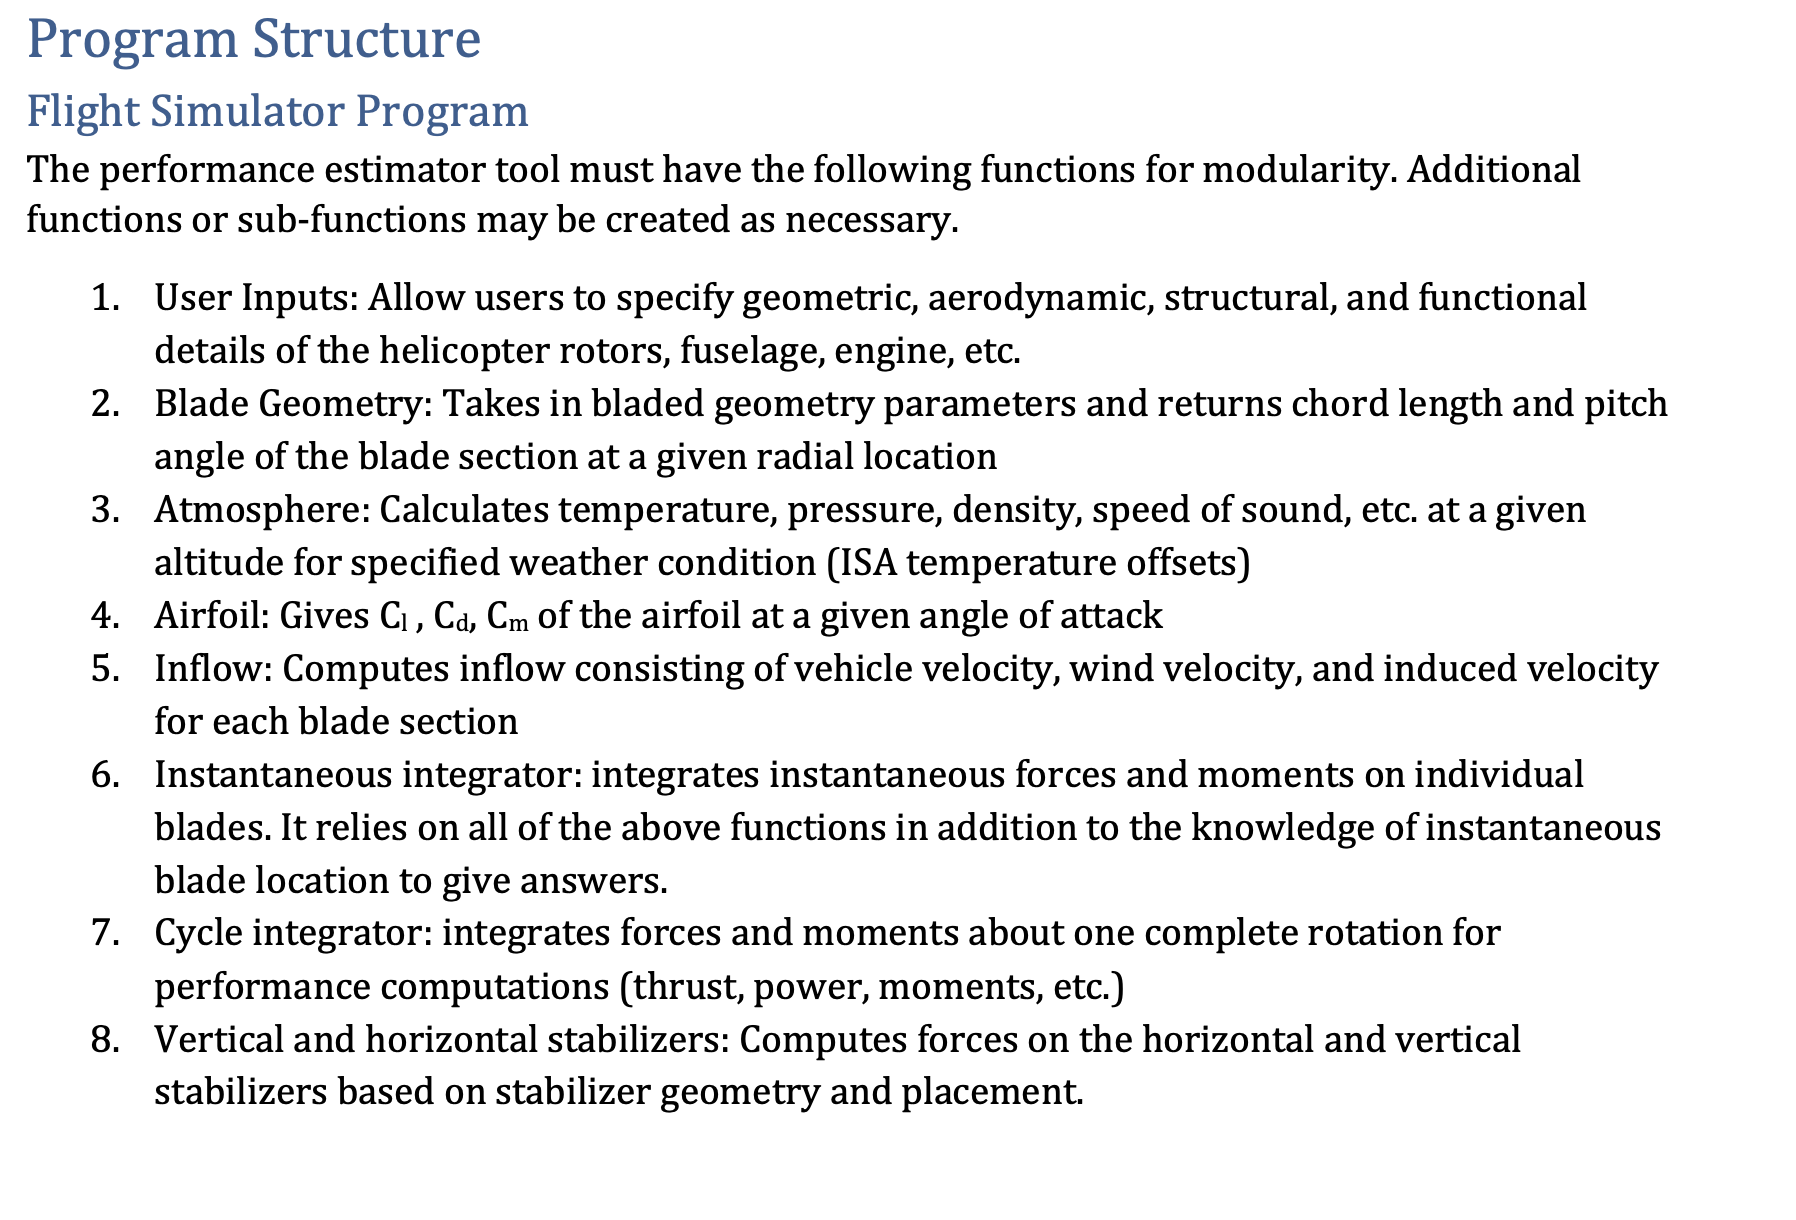

In [84]:
import numpy as np
import math
from typing import Callable, Tuple, Dict

In [80]:
# Rotor Geometrical parameters (UH-60 reference / NASA math model + planform data)
rotor = {
    "b": 4,                         # number of blades (UH-60)  -- NASA table. :contentReference[oaicite:1]{index=1}
    "Rr": 1.55378,                  # blade root cutout radius [m] (≈ 0.19 * Rt) -- root cutout ≈19%R reported in literature. :contentReference[oaicite:2]{index=2}
    "Rt": 8.17778,                  # blade tip radius [m] (26.83 ft -> 8.17778 m). :contentReference[oaicite:3]{index=3}
    "chord_root": 0.527304,         # mean blade chord [m] (1.73 ft -> 0.5273 m) — NASA planform chord / SC1095 family. :contentReference[oaicite:4]{index=4}
    "chord_tip": 0.527304,          # tip chord (UH-60 planform is close to near-constant chord in cited sources). :contentReference[oaicite:5]{index=5}
    "theta_root": 10.0,             # root incidence [deg] — chosen such that blade twist = root - tip = ~18° (see theta_tip). (estimate guided by NASA twist). :contentReference[oaicite:6]{index=6}
    "theta_tip": 0             # tip incidence [deg] — chosen to give total twist ≈ -18° (NASA: blade twist = -0.3142 rad ≈ -18°). :contentReference[oaicite:7]{index=7}
}

# Rotor aerodynamic parameters (from NASA airfoil studies + reasonable approximations)
rotor_aero = {
    "Cl_alpha": 5.73,               # lift-curve slope [1/rad] (NASA UH-60 math model value). :contentReference[oaicite:8]{index=8}
    "Cl0": 0.2,                     # zero-angle lift coefficient (approx for SC1095 family; used commonly in UH-60 analyses). :contentReference[oaicite:9]{index=9}
    "Cd0": 0.01,                    # profile (zero-lift) drag coefficient — small, order-of-magnitude estimate (airfoil dependent; NASA gives Cd trends vs Re). :contentReference[oaicite:10]{index=10}
    "e": 0.8,                       # Oswald/efficiency (typical rotor/airfoil effective value for performance estimates) — approximate.
    "alpha0": -1.0,                 # zero-lift AoA [deg] (SC1095/SC1094-R8 values near -0.1 to -1.7 deg in wind-tunnel datasets -> use -1°). :contentReference[oaicite:11]{index=11}
    "Cm0": -0.020,                  # pitching moment at zero lift (airfoil-based; NASA airfoil data suggests ~ -0.015 to -0.03). :contentReference[oaicite:12]{index=12}
    "Cm_alpha": -0.5                # pitching moment slope [1/rad] (order-of-magnitude estimate; negative for cambered rotor sections).
}

# Engine parameters (GE T700 values & UH-60M figures)
engine = {
    # UH-60M uses two GE T700-series engines; the -701D is often quoted ~1,994 shp per engine (value in Sikorsky/archives/refs).
    # Convert to Watts: 1 shp = 745.699872 W
    "power_per_engine_shp": 1994.0,                               # shp (per engine, UH-60M / -701D quoted value). :contentReference[oaicite:13]{index=13}
    "power_per_engine_W": 1994.0 * 745.699872,                    # ≈ 1.4869e6 W per engine (computed)
    "power_avail": 1994.0 * 745.699872 * 2.0,                     # combined power available (both engines) [W] ≈ 2.97385e6 W
    "omega": 27.0                                                 # rotor angular speed [rad/s] (nominal UH-60 main rotor angular speed in NASA table). :contentReference[oaicite:14]{index=14}
}

# Fuselage parameters (from UH-60 math model and reasonable geometric estimates)
# NOTE: Some fuselage aerodynamic coefficients are fit empirically in the NASA UH-60 model;
# the NASA TM provides the fuselage aerodynamic model and reference values — below are the representative parameter choices.
fuselage = {
    "Cdx": 0.7156,       # approximate longitudinal (X) fuselage drag coefficient used/derived in UH-60 regressions (from NASA table data). :contentReference[oaicite:15]{index=15}
    "Cdy": 0.89,         # approximate lateral (Y) fuselage drag coefficient (from same regression outputs). :contentReference[oaicite:16]{index=16}
    "Cdz": 0.651,        # approximate vertical (Z) fuselage coefficient (from same regression outputs). :contentReference[oaicite:17]{index=17}
    "X_area": 3.0,       # frontal area [m²] (approximate; typical medium-lift helicopter frontal area ~2.5–4 m²). (estimate)
    "Y_area": 4.0,       # side area [m²] (estimate)
    "Z_area": 7.0        # top area [m²] (estimate; used for downwash & stabilator interaction modeling)
}

# Stabilizer parameters (horizontal / vertical) — NASA model lists stabilator geometry and behavior
horizontal_stabilizers = {
    "horiz_area": 4.18,    # horizontal stabilator area [m²] (~45 ft² -> 4.18 m²) — NASA table lists ≈45.0 (units in ft^2). :contentReference[oaicite:18]{index=18}
    "horiz_Cd": 0.05,      # representative small aerofoil drag coefficient (estimate)
    "horiz_arm": 5.0       # moment arm [m] from c.g. to horizontal stabilator (estimate; matches typical tail moment arms)
}

vertical_stabilizers = {
    "verti_area": 1.92,    # vertical fin area [m²] (~20.7 ft² -> 1.92 m² shown in NASA table). :contentReference[oaicite:19]{index=19}
    "verti_Cd": 0.05,      # small representative drag coefficient (estimate)
    "verti_arm": 5.0       # moment arm [m] (estimate)
}

# Flight condition (kept as you provided; altitude 2000 m is fine)
flight_condition = {
    "altitude": 20,           # Altitude [m]  (you provided already)
    "velocity": [0, 0, 0],      # body velocities [u,v,w] m/s (hover / trimmed example)
    "wind": [0, 0, 0],          # wind [m/s]
    "delta_ISA": 5              # ISA temperature offset [K]
}


In [56]:

def atmosphere(altitude, delta_ISA=0.0):
    """
    Calculates temperature, pressure, density, and speed of sound 
    at a given altitude with ISA temperature offset.
    
    Inputs:
        altitude   : Altitude [m]
        delta_ISA  : ISA temperature offset [K] (default = 0)
        
    Returns:
        dict with T [K], p [Pa], rho [kg/m³], a [m/s]
    """
    
    # Constants
    T0 = 288.15      # Sea level standard temp [K]
    p0 = 101325.0    # Sea level standard pressure [Pa]
    rho0 = 1.225     # Sea level density [kg/m³]
    a0 = 340.294     # Sea level speed of sound [m/s]
    g = 9.80665      # Gravity [m/s²]
    R = 287.058      # Gas constant for air [J/kg-K]
    L = -0.0065      # Temperature lapse rate [K/m] up to 11 km
    
    # Troposphere only (0–11 km)
    if altitude <= 11000:
        T = T0 + L * altitude + delta_ISA
        p = p0 * (T / (T0 + delta_ISA)) ** (-g / (L * R))
    else:
        # Very simplified: isothermal above 11 km
        T = 216.65 + delta_ISA
        p = p0 * (T / (T0 + delta_ISA)) ** (-g / (L * R)) \
            * math.exp(-g * (altitude - 11000) / (R * T))
    
    rho = p / (R * T)
    a = math.sqrt(1.4 * R * T)
    
    return {"T": T, "p": p, "rho": rho, "a": a}


In [57]:
atm = atmosphere(altitude=15000, delta_ISA=5)

print("Temperature:", round(atm["T"], 2), "K")
print("Pressure:", round(atm["p"], 2), "Pa")
print("Density:", round(atm["rho"], 4), "kg/m³")
print("Speed of sound:", round(atm["a"], 2), "m/s")


Temperature: 221.65 K
Pressure: 12583.43 Pa
Density: 0.1978 kg/m³
Speed of sound: 298.46 m/s


In [58]:
def airfoil_lift(Cl0, Cl_alpha, alpha0, alpha):
    """
    Calculates lift coefficient for a given airfoil at a specified angle of attack in degrees.
    """
    alpha_rad = math.radians(alpha)
    alpha0_rad = math.radians(alpha0)
    Cl = Cl0 + Cl_alpha * (alpha_rad - alpha0_rad)
    return Cl

def airfoil_drag(Cd0, Cl, e, AR):
    """
    Calculates drag coefficient using parabolic drag polar.
    """
    Cd = Cd0 + (Cl ** 2) / (math.pi * AR * e)
    return Cd

def airfoil_moment(Cm0, Cm_alpha,alpha0, alpha):
    """
    Calculates pitching moment coefficient for a given airfoil.
    """
    alpha_rad = math.radians(alpha)
    alpha0_rad = math.radians(alpha0)
    Cm = Cm0 + Cm_alpha * (alpha_rad - alpha0_rad)
    return Cm

In [59]:
def chord_r(root_chord, tip_chord, r):
    """
    Calculates the chord length at a given radius assuming linear variation from root to tip.
    """
    return root_chord + (tip_chord - root_chord) * (r - rotor["Rr"]) / (rotor["Rt"] - rotor["Rr"])

In [60]:
def pitch_x(theta_root, theta_tip,r):
    """
    Calculates the pitch angle along the blade span assuming linear variation from root to tip in degrees
    """
    return theta_root + (theta_tip - theta_root) * (r - rotor["Rr"]) / (rotor["Rt"] - rotor["Rr"])

In [61]:

def solidity(b: int, c_root: float, c_tip: float, R: float, R_root: float = 0.0) -> float:
    """
    Rotor solidity for linearly tapered chord with a root cut-out.

    Formula:
    σ = (Nb * (R - R_root) * (c_root + c_tip) / 2) / (π * R^2)

    Nb:     number of blades [-]
    c_root: chord at R_root [m]
    c_tip:  chord at R [m]
    R:      rotor tip radius [m]
    R_root: root cut-out radius [m]
    """
    if not (0 <= R_root < R):
        raise ValueError("Require 0 <= R_root < R")
    span = R - R_root
    avg_chord = 0.5 * (c_root + c_tip)
    return (b * avg_chord * span) / (math.pi * R**2)

# Function Definitions for BEMT

In [62]:
## inflow calculator 
def Lambda(sigma, a, theta, r, R, V, Omega, R_root=0.0):
    """
    Computes inflow ratio (lambda) at a blade section, accounting for root cut-out.

    Parameters:
    sigma   : float   # Rotor solidity
    a       : float   # Lift curve slope (per rad)
    theta   : float   # Pitch angle (deg)
    r       : float   # Radial location (m)
    R       : float   # Rotor tip radius (m)
    V       : float   # Freestream velocity (m/s)
    Omega   : float   # Rotor angular speed (rad/s)
    R_root  : float   # Root cut-out radius (m), default 0

    Returns:
    lambda_val : float
    """

    # Effective span and normalized radius
    span = R - R_root
    r_bar = (r - R_root) / span  # normalized radius from root cut-out

    theta_r = math.radians(theta)
    lambda_c = V / (Omega * R)

    term1 = (sigma * a / 16) - (lambda_c / 2)
    term2 = (sigma * a / 8) * theta_r * r_bar

    lambda_val = math.sqrt(term1**2 + term2) - term1

    return lambda_val

In [63]:
def induced_velocity(Lambda,Omega,R,V):
    """
    Computes induced velocity at the rotor disk for a given inflow ratio.

    Parameters:
    lambda : float  # Inflow ratio
    Omega  : float  # Rotor angular speed (rad/s)
    R      : float  # Rotor radius (m)

    Returns:
    vi : float
    """
    vi = Lambda * Omega * R - V
    return vi
    
   

### Incorporing Prandatl;s Tip Loss model

In [64]:
def LambdaP_hover(sigma, a, F, theta, r, R_tip, R_root=0.0):
    """
    Computes inflow ratio (lambda) for hover with Prandtl's tip loss, accounting for root cut-out.

    Parameters:
    sigma   : float   # Rotor solidity
    a       : float   # Lift curve slope (per rad)
    F       : float   # Tip loss factor
    theta   : float   # Pitch angle (deg)
    r       : float   # Radial location (m)
    R       : float   # Rotor tip radius (m)
    R_root  : float   # Root cut-out radius (m), default 0

    Returns:
    lam     : float   # Inflow ratio
    """
    theta_rad = math.radians(theta)
    term = 1 + (32 * F / (sigma * a)) * theta_rad * r/R_tip
    lam = (sigma * a / (16 * F)) * (math.sqrt(term) - 1)
    return lam

In [65]:
def LambdaP_climb(sigma, a, F, theta, r, R_tip, lambda_c, R_root=0.0):
    """
    Computes inflow ratio (lambda) for climb with Prandtl's tip loss, accounting for root cut-out.

    Parameters:
    sigma     : float   # Rotor solidity
    a         : float   # Lift curve slope (per rad)
    F         : float   # Tip loss factor
    theta     : float   # Pitch angle (rad)
    r         : float   # Radial location (m)
    R         : float   # Rotor tip radius (m)
    lambda_c  : float   # Advance ratio (V / Omega R)
    R_root    : float   # Root cut-out radius (m), default 0

    Returns:
    lam       : float   # Inflow ratio
    """

    theta_rad = math.radians(theta)
    term1 = (sigma * a) / (16 * F) - (lambda_c / 2)
    term2 = (sigma * a / (8 * F)) * theta_rad * r/R_tip
    lam = math.sqrt(term1**2 + term2) - term1
    return lam

In [76]:
def tip_loss_factor(b, r, R_tip, lam, R_root=0.0):
    """
    Computes Prandtl's tip loss factor, accounting for root cut-out.

    Parameters:
    b      : int    # Number of blades
    r      : float  # Radial location (m)
    R      : float  # Rotor tip radius (m)
    lam    : float  # Local inflow ratio
    R_root : float  # Root cut-out radius (m), default 0

    Returns:
    F      : float  # Tip loss factor
    """
    if lam == 0:
        return 1.0
    f = (b / 2) * (1 - r/R_tip) / lam
    F = (2 / math.pi) * math.acos(math.exp(-f))
    return F

In [67]:
def compute_phi(V, v, Omega, r, R_root=0.0):
    """
    Computes the inflow angle (phi) at a blade section and returns it in degrees.

    Parameters:
    V      : float  # Freestream velocity (m/s)
    v      : float  # Induced velocity (m/s)
    Omega  : float  # Rotor angular speed (rad/s)
    r      : float  # Radial location (m), should be >= R_root
    R_root : float  # Root cut-out radius (m), default 0

    Returns:
    phi_deg : float  # Inflow angle in degrees
    """
    Ut = Omega * r
    Up = V + v
    phi_rad = math.atan2(Up, Ut)
    phi_deg = math.degrees(phi_rad)
    return phi_deg

### Iterative solver 

In [90]:
def iterative_solver(
    b: int,
    rho: float,
    Ut_fn: Callable[[float], float],
    Up_fn: Callable[[float], float],
    c_fn: Callable[[float], float],
    Cl_fn: Callable[[float], float],
    phi_fn: Callable[[float], float],
    Cd_fn: Callable[[float], float],
    R_root: float,
    R_tip: float,
    N0: int = 64,
    max_iter: int = 8,
    tol: float = 1e-6
) -> Dict:
    """
    Compute thrust T, drag D, torque Q, and power P by iteratively refining the radial grid until convergence.

    Returns
    -------
    dict with keys:
        T : converged thrust (N)
        D : converged drag (N)
        Q : converged torque (Nm)
        P : converged power (W)
        N : number of radial points used
        r, dT_dr_per_blade, dD_dr_per_blade, dQ_dr_per_blade, dP_dr_per_blade, q : arrays for the final grid
        history_T : list of thrust values by iteration
        history_D : list of drag values by iteration
        history_Q : list of torque values by iteration
        history_P : list of power values by iteration
    """
    def compute_T_D_Q_P_on_grid(N: int) -> Tuple[float, float, float, float, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        r = np.linspace(R_root, R_tip, N)
        Ut = np.array([Ut_fn(ri) for ri in r])
        Up = np.array([Up_fn(ri) for ri in r])
        c  = np.array([c_fn(ri)  for ri in r])
        Cl = np.array([Cl_fn(ri) for ri in r])
        phi = np.array([phi_fn(ri) for ri in r])
        Cd = np.array([Cd_fn(ri) for ri in r])

        V2 = Ut**2 + Up**2
        q = 0.5 * rho * V2
        phi_r = np.radians(phi)

        # per-blade elemental thrust, drag, torque, and power density
        dT_dr_1b = q * c * (Cl * np.cos(phi_r) - Cd * np.sin(phi_r))
        dD_dr_1b = q * c * (Cl * np.sin(phi_r) + Cd * np.cos(phi_r))
        dQ_dr_1b = r * q * c * (Cd * np.cos(phi_r) + Cl * np.sin(phi_r))
        dP_dr_1b = Ut * dQ_dr_1b  # Power = Omega*r * dQ_dr_1b

        # integrate using trapezoidal rule and multiply by b
        T = b * np.trapezoid(dT_dr_1b, r)
        D = b * np.trapezoid(dD_dr_1b, r)
        Q = b * np.trapezoid(dQ_dr_1b, r)
        P = b * np.trapezoid(dP_dr_1b, r)
        return T, D, Q, P, r, dT_dr_1b, dD_dr_1b, dQ_dr_1b, dP_dr_1b, q

    N = max(8, int(N0))
    history_T = []
    history_D = []
    history_Q = []
    history_P = []
    T_prev = None
    D_prev = None
    Q_prev = None
    P_prev = None

    for it in range(max_iter):
        T, D, Q, P, r, dT_dr_1b, dD_dr_1b, dQ_dr_1b, dP_dr_1b, q = compute_T_D_Q_P_on_grid(N)
        history_T.append(T)
        history_D.append(D)
        history_Q.append(Q)
        history_P.append(P)

        if T_prev is not None and abs(T - T_prev) <= tol and abs(D - D_prev) <= tol and abs(Q - Q_prev) <= tol and abs(P - P_prev) <= tol:
            return {
                "T": float(T),
                "D": float(D),
                "Q": float(Q),
                "P": float(P),
                "N": N,
                "r": r,
                "dT_dr_per_blade": dT_dr_1b,
                "dD_dr_per_blade": dD_dr_1b,
                "dQ_dr_per_blade": dQ_dr_1b,
                "dP_dr_per_blade": dP_dr_1b,
                "q": q,
                "history_T": history_T,
                "history_D": history_D,
                "history_Q": history_Q,
                "history_P": history_P
            }
        T_prev = T
        D_prev = D
        Q_prev = Q
        P_prev = P
        N = N * 2

    return {
        "T": float(T),
        "D": float(D),
        "Q": float(Q),
        "P": float(P),
        "N": N // 2,
        "r": r,
        "dT_dr_per_blade": dT_dr_1b,
        "dD_dr_per_blade": dD_dr_1b,
        "dQ_dr_per_blade": dQ_dr_1b,
        "dP_dr_per_blade": dP_dr_1b,
        "q": q,
        "history_T": history_T,
        "history_D": history_D,
        "history_Q": history_Q,
        "history_P": history_P,
        "warning": "Did not converge within max_iter"
    }

In [71]:
def solve_lambda_tiploss(sigma, a, b, theta_deg, r, R_tip, R_root=0.0, tol=1e-5, max_iter=20):
    """
    Iteratively solves for lambda and Prandtl's tip loss factor F at a blade station.
    Starts from F=1, updates lambda and F until convergence.
    Returns: (lambda, F)
    """
    F = 1.0
    for _ in range(max_iter):
        lam_new = LambdaP_hover(sigma, a, F, theta_deg, r, R_tip, R_root)
        F_new = tip_loss_factor(b, r, R_tip, lam_new, R_root)
        if abs(F_new - F) < tol:
            return lam_new, F_new
        F = F_new
    return lam_new, F_new  # Return last values if not converged

### Calling the iteraror for main rotor

In [101]:
import pandas as pd

# ...existing code...

b = rotor["b"]
altitude = flight_condition["altitude"]
rho = atmosphere(altitude, delta_ISA=flight_condition["delta_ISA"])["rho"]
R_tip  = rotor["Rt"]
R_root = rotor["Rr"]
C_tip = rotor["chord_tip"]
C_root = rotor["chord_root"]
Omega = engine["omega"]

sigma = solidity(b, C_root,C_tip, R_tip)
a = rotor_aero["Cl_alpha"]

V_val = flight_condition["velocity"][0]

# Pitch angle as a function of r
theta_fn = lambda r: pitch_x(rotor["theta_root"], rotor["theta_tip"], r)

# Inflow ratio lambda as a function of r, with tip loss factor
lembda_fn = lambda r: solve_lambda_tiploss(sigma, a, b, theta_fn(r), r, R_tip, R_root)[0]
#F_fn      = lambda r: solve_lambda_tiploss(sigma, a, b, theta_fn(r), r, R_tip, R_root)[1]

# Induced velocity as a function of r
v_fn = lambda r: induced_velocity(lembda_fn(r), Omega, R_tip, V_val)

# Inflow angle phi as a function of r
phi_fn = lambda r: compute_phi(V_val, v_fn(r), Omega, r, R_root)

# Chord as a function of r
c_fn = lambda r: chord_r(C_root, C_tip, r)

# Lift coefficient as a function of r
Cl_fn = lambda r: airfoil_lift(
    Cl0=rotor_aero["Cl0"],
    Cl_alpha=rotor_aero["Cl_alpha"],
    alpha0=rotor_aero["alpha0"],
    alpha = theta_fn(r) - phi_fn(r)
)

# Aspect ratio estimate for drag calculation
AR = (R_tip - R_root) / ((C_root + C_tip) / 2)

# Drag coefficient as a function of r
Cd_fn = lambda r: airfoil_drag(
    Cd0=rotor_aero["Cd0"],
    Cl=Cl_fn(r),
    e=rotor_aero["e"],
    AR=AR
)

# Now run the iterative thrust calculation
res = iterative_solver(
    b=b, rho=rho,
    Ut_fn=lambda r: Omega * r,
    Up_fn=lambda r: V_val + v_fn(r),
    c_fn=c_fn, Cl_fn=Cl_fn, phi_fn=phi_fn, Cd_fn=Cd_fn,
    R_root=R_root, R_tip=R_tip,
    N0=64, max_iter=6, tol=1e-5
)

# Print scalar variables
print("b =", b)
print("rho =", rho)
print("R_tip =", R_tip)
print("R_root =", R_root)
print("Omega =", Omega)
print("sigma =", sigma)
print("a =", a)
print("V_val =", V_val)
print("AR =", AR)

# Tabulate sample values at selected radial positions
sample_r = [R_root, (R_root+R_tip)/2, R_tip]
table = []
for r in sample_r:
    table.append({
        "r (m)": round(r, 2),
        "theta (deg)": round(theta_fn(r), 3),
        "F (tip loss)": round(tip_loss_factor(b, r, R_tip, lembda_fn(r)), 4),
        "lambda": round(lembda_fn(r), 5),
        "v_induced (m/s)": round(v_fn(r), 4),
        "phi (deg)": round(phi_fn(r), 3),
        "chord (m)": round(c_fn(r), 4),
        "Cl": round(Cl_fn(r), 4),
        "Cd": round(Cd_fn(r), 5)
    })
df = pd.DataFrame(table)
print("\nSample values at selected r:")
print(df.to_string(index=False))

# Tabulate arrays from iterative_thrust result (first 5 values for brevity)
tab_array = pd.DataFrame({
    "r (m)": res["r"],
    "dT_dr_per_blade": res["dT_dr_per_blade"],
    "dD_dr_per_blade": res["dD_dr_per_blade"],
    "dQ_dr_per_blade": res["dQ_dr_per_blade"],
    "dP_dr_per_blade": res["dP_dr_per_blade"],
    "q": res["q"]
})
print("\nElemental values along blade (first 5 rows):")
print(tab_array.head().to_string(index=False))

# Print histories and converged values

print("\nConverged T (Thrust) =", res["T"], "N")
print("Converged D (Drag)   =", res["D"], "N")
print("Converged Q (Torque) =", res["Q"], "Nm")
print("Converged P (Power)  =", res["P"], "W")

print("Grid points used  =", res["N"])
if "warning" in res:
    print("Warning:", res["warning"])
# ...existing code...

b = 4
rho = 1.2018139700205943
R_tip = 8.17778
R_root = 1.55378
Omega = 27.0
sigma = 0.08209860193072328
a = 5.73
V_val = 0
AR = 12.562013563333487

Sample values at selected r:
 r (m)  theta (deg)  F (tip loss)  lambda  v_induced (m/s)  phi (deg)  chord (m)     Cl      Cd
  1.55         10.0           1.0 0.02365           5.2219      7.095     0.5273 0.5905 0.02104
  4.87          5.0           1.0 0.03319           7.3284      3.193     0.5273 0.4807 0.01732
  8.18          0.0           1.0 0.00000           0.0000      0.000     0.5273 0.3000 0.01285

Elemental values along blade (first 5 rows):
   r (m)  dT_dr_per_blade  dD_dr_per_blade  dQ_dr_per_blade  dP_dr_per_blade           q
1.553780       330.374455        53.132059        82.555531      3463.374604 1073.966910
1.557016       331.807201        53.327404        83.031619      3490.601982 1078.417191
1.560252       333.242794        53.522955        83.509292      3517.979374 1082.876623
1.563488       334.681232        53.

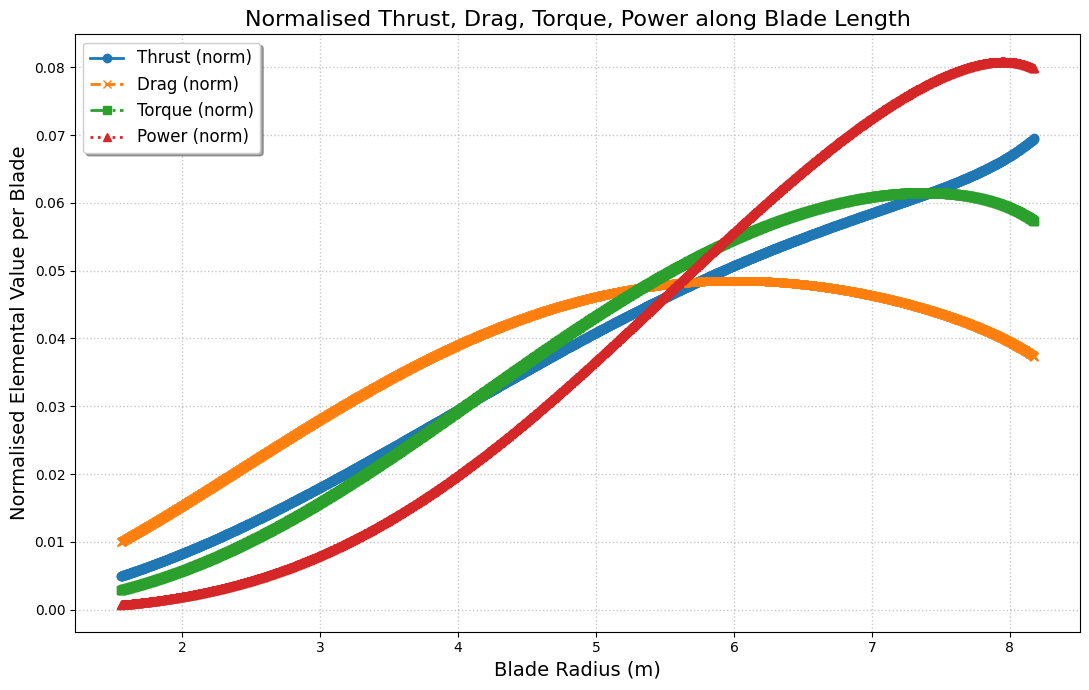

In [103]:
import matplotlib.pyplot as plt

r_array = res["r"]
dT_dr_array = res["dT_dr_per_blade"]
dD_dr_array = res["dD_dr_per_blade"]
dQ_dr_array = res["dQ_dr_per_blade"]
dP_dr_array = res["dP_dr_per_blade"]

# Normalise by converged values
T_total = res["T"]
D_total = res["D"]
Q_total = res["Q"]
P_total = res["P"]

dT_dr_norm = dT_dr_array / T_total
dD_dr_norm = dD_dr_array / D_total
dQ_dr_norm = dQ_dr_array / Q_total
dP_dr_norm = dP_dr_array / P_total

plt.figure(figsize=(11,7))
plt.plot(r_array, dT_dr_norm, label="Thrust (norm)", marker='o', linestyle='-', linewidth=2)
plt.plot(r_array, dD_dr_norm, label="Drag (norm)", marker='x', linestyle='--', linewidth=2)
plt.plot(r_array, dQ_dr_norm, label="Torque (norm)", marker='s', linestyle='-.', linewidth=2)
plt.plot(r_array, dP_dr_norm, label="Power (norm)", marker='^', linestyle=':', linewidth=2)

plt.xlabel("Blade Radius (m)", fontsize=14)
plt.ylabel("Normalised Elemental Value per Blade", fontsize=14)
plt.title("Normalised Thrust, Drag, Torque, Power along Blade Length", fontsize=16)
plt.legend(fontsize=12, loc="best", frameon=True, shadow=True)
plt.grid(True, which='both', linestyle=':', linewidth=1, alpha=0.7)
plt.tight_layout()

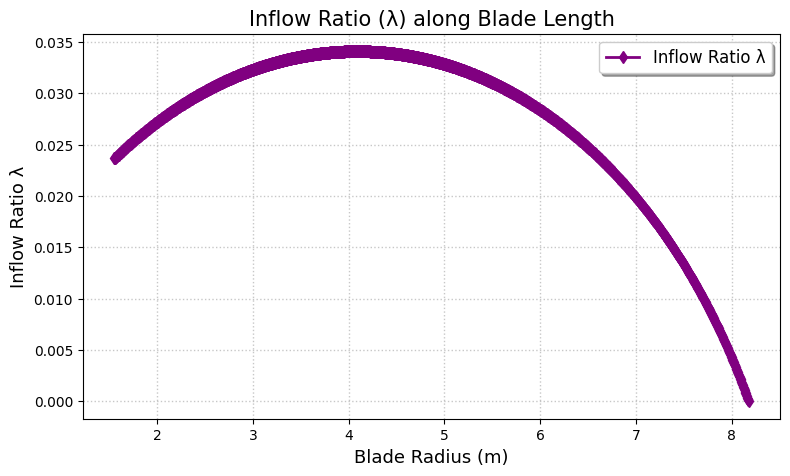

In [95]:
# Plot lambda (inflow ratio) as a function of r
r_array = res["r"]
lembda_array = np.array([lembda_fn(r) for r in r_array])

plt.figure(figsize=(9,5))
plt.plot(r_array, lembda_array, color='purple', marker='d', linestyle='-', linewidth=2, label='Inflow Ratio λ')
plt.xlabel("Blade Radius (m)", fontsize=13)
plt.ylabel("Inflow Ratio λ", fontsize=13)
plt.title("Inflow Ratio (λ) along Blade Length", fontsize=15)
plt.legend(fontsize=12, frameon=True, shadow=True)
plt.grid(True, linestyle=':', linewidth=1, alpha=0.7)